In [50]:
import torch
from pysmo.sac import sacio, sacfunc
import numpy as np
import librosa
from librosa import display
import matplotlib.pyplot as plt
import os
from tqdm import tnrange
import random
import h5py
from audio_embed import utilities
utilities.apply_style()
%matplotlib inline

In [51]:
folders = ['SAC_20041226_2_XF', 'SAC_20010126_XF', 'SAC_20021102_XF/', 'SAC_20050328_XF', 'SAC_20041226_XF', 'SAC_20050724_XF', '20100227'] 

In [52]:
def read_surface_window(f):
    f = open(f)
    times = [s.rstrip().split(' ') for s in f.readlines()]
    d = {}
    for time in times:
        d[time[0].split('BH')[0]] = (float(time[1]), float(time[2]))
    f.close()
    return d

def load_data(directory):
    earthquakes = []
    earthquake_files = [x for x in os.listdir(directory) if '.SAC' in x]
    progress_bar = tnrange(len(earthquake_files))
    shape = None
    if len(earthquake_files) == 0:
        return []
    
    surface_window = read_surface_window(os.path.join(directory, 'surface_window.txt'))
    for i in progress_bar:
        earthquake_file = earthquake_files[i]
        progress_bar.set_description(os.path.join(directory, earthquake_file))
        earthquake = sacio.sacfile(os.path.join(directory, earthquake_file))
        sample_rate = np.round(1./earthquake.delta)
        t, data = sacfunc.sac2xy(earthquake)
        start, stop = surface_window[earthquake_file.split('BH')[0]]
        start, stop = int(sample_rate*start), int(sample_rate*stop)
        data = np.array(data)[start:stop]
        if data.shape[0] > 0:
            earthquakes.append(data)
    return earthquakes


random.shuffle(folders)
positive_earthquakes = []
for i, f in enumerate(folders):
    if i == len(folders) - 1:
        positive_cutoff = len(positive_earthquakes)
        print positive_cutoff
    positive_earthquakes += load_data(os.path.join('data', f, 'positive'))
print len(positive_earthquakes)

negative_earthquakes = []
for i, f in enumerate(folders):
    if i == len(folders) - 1:
        negative_cutoff = len(negative_earthquakes)
        print negative_cutoff
    negative_earthquakes += load_data(os.path.join('data', f, 'negative'))
print len(negative_earthquakes)

HBox(children=(IntProgress(value=0, max=75), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=95), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=325), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=105), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=250), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=220), HTML(value=u'')))


1070


HBox(children=(IntProgress(value=0, max=117), HTML(value=u'')))


1187


HBox(children=(IntProgress(value=0, max=75), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=190), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=15), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=888), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=20), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=125), HTML(value=u'')))


1308


HBox(children=(IntProgress(value=0, max=162), HTML(value=u'')))


1470


In [164]:
folders

['SAC_20021102_XF/',
 'SAC_20050328_XF',
 '20100227',
 'SAC_20010126_XF',
 'SAC_20041226_2_XF',
 'SAC_20050724_XF',
 'SAC_20041226_XF']

In [71]:
#TODO: Whiten across all station data
#TODO: Data augmentation by adding high pass from one station to a low pass of another

def extract_features(data, sr=40.0):
    raw_data = data
    return raw_data[0:32768]

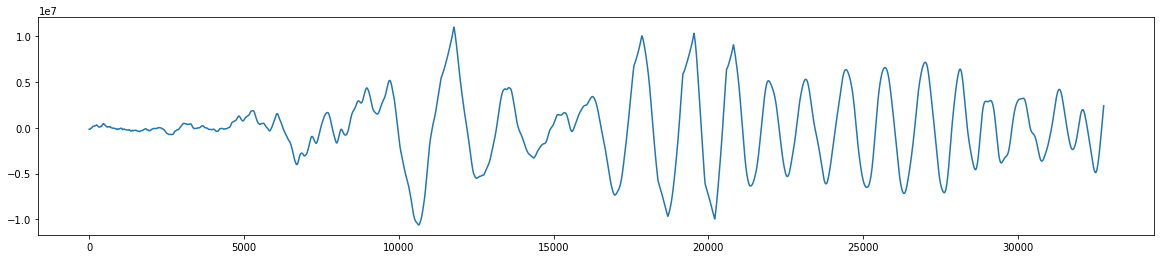

In [72]:
plt.figure(figsize=(20, 4))
plt.plot(extract_features(positive_earthquakes[-200]))
plt.show()

In [73]:
rm earthquakes_time_series.h5

In [74]:
import h5py
shape = (1,) + extract_features(positive_earthquakes[0]).shape

dataset = h5py.File('earthquakes_time_series.h5', 'w')
dataset.create_group('training')
dataset.create_group('testing')

split = 'training'
amount_for_testing = positive_cutoff

dataset[split].create_dataset('data', 
                                   shape=shape, 
                                   maxshape=(None, None)) 
dataset[split].create_dataset('label', 
                                   shape=(1, 1), 
                                   maxshape=(None, None))

for i in tnrange(positive_cutoff):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(positive_earthquakes[i])
    dataset[split]['label'][current_size - 1] = 1
    dataset[split]['data'].resize(current_size + 1, axis = 0)
    dataset[split]['label'].resize(current_size + 1, axis = 0)
    
for i in tnrange(negative_cutoff):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(negative_earthquakes[i])
    dataset[split]['label'][current_size - 1] = 0
    if i < (len(negative_earthquakes) - 5) - 1:
        dataset[split]['data'].resize(current_size + 1, axis = 0)
        dataset[split]['label'].resize(current_size + 1, axis = 0)

split = 'testing'

dataset[split].create_dataset('data', 
                                   shape=shape, 
                                   maxshape=(None, None)) 
dataset[split].create_dataset('label', 
                                   shape=(1, 1), 
                                   maxshape=(None, None))
for i in tnrange(positive_cutoff, len(positive_earthquakes)):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(positive_earthquakes[i])
    dataset[split]['label'][current_size - 1] = 1
    dataset[split]['data'].resize(current_size + 1, axis = 0)
    dataset[split]['label'].resize(current_size + 1, axis = 0)
    
for i in tnrange(negative_cutoff, len(negative_earthquakes)):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(negative_earthquakes[i])
    dataset[split]['label'][current_size - 1] = 0
    if i < len(negative_earthquakes) - 1:
        dataset[split]['data'].resize(current_size + 1, axis = 0)
        dataset[split]['label'].resize(current_size + 1, axis = 0)

HBox(children=(IntProgress(value=0, max=1070), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=1308), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=117), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=162), HTML(value=u'')))

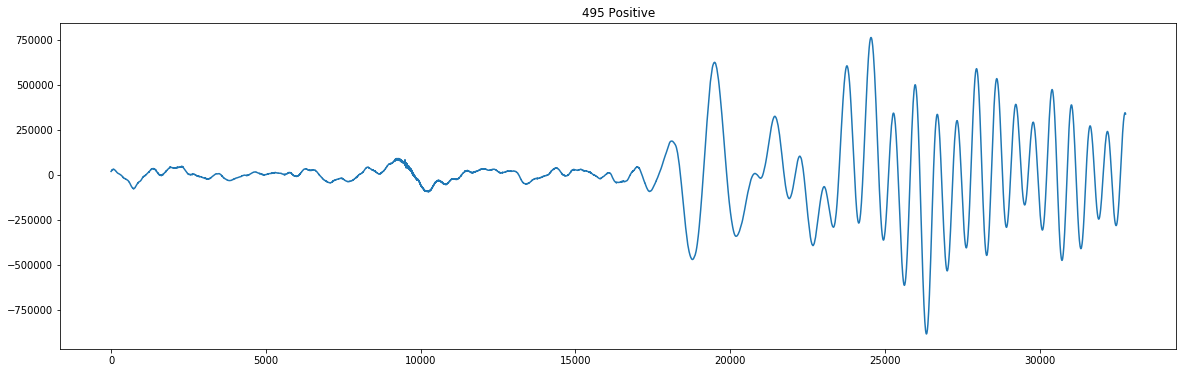

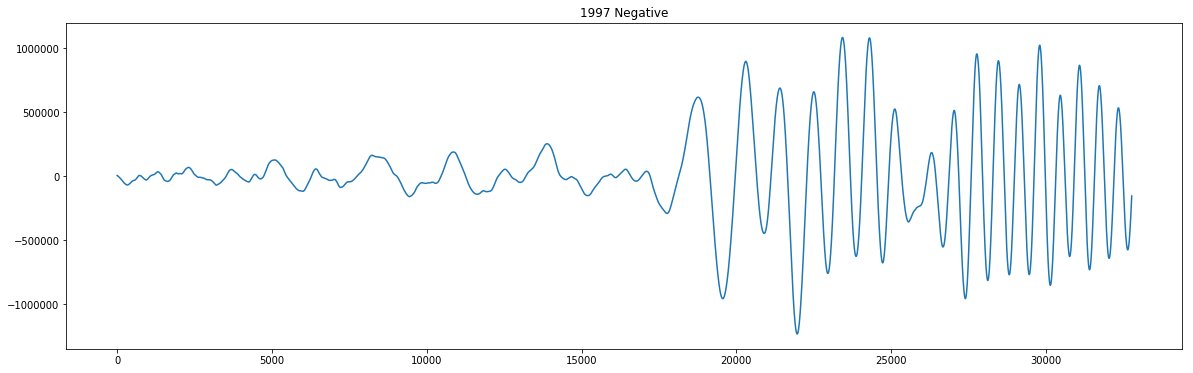

In [75]:
def show_datapoint(i, split):
    mean = np.mean(dataset['training']['data'])
    std = np.std(dataset['training']['data'])
    labels = ['Negative', 'Positive']
    plt.figure(figsize=(20, 6))
    plt.plot(dataset[split]['data'][i].T)

    plt.title(str(i) + ' ' + labels[int(dataset[split]['label'][i][0])])
    plt.show()

show_datapoint(random.choice(range(dataset['training']['data'].shape[0])), 'training')
show_datapoint(random.choice(range(dataset['training']['data'].shape[0])), 'training')

In [90]:
dataset = h5py.File('earthquakes_time_series.h5', 'r')

In [76]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

def show_model(model):
    print model
    num_parameters = 0
    for p in model.parameters():
        if p.requires_grad:
            num_parameters += np.cumprod(p.size())[-1]
    print 'Number of parameters: %d' % num_parameters
    
def convert_to_tensor(data):
    tensor = torch.FloatTensor(data)
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 32, kernel_size=3, padding=1, stride=2),
            nn.ReLU(inplace=True))
        self.fc1 = nn.Sequential(
            nn.Linear(32*128, 32))       
        
    def forward_once(self, input_data):
        num_batch = input_data.size(0)
        input_data = input_data.unsqueeze(1)
        output = self.cnn1(input_data)
        output = output.view(num_batch, -1)
        embedding = self.fc1(output)
        #embedding = nn.functional.normalize(embedding, p=2, dim=-1)
        return embedding
    
    def forward(self, input_one, input_two):
        output_one = self.forward_once(input_one)
        output_two = self.forward_once(input_two)
        return output_one, output_two

def whiten(data, mean, std):
    data -= mean
    data /= std + 1e-8
    return data

def collect_data(dataset, indices):
    data = []
    labels = []
    for i in indices:
        data += [dataset['data'][i]]
        labels += [dataset['label'][i]]
    return np.array(data), np.array(labels)

net = SiameseNetwork().cuda()
net.train()
show_model(net)
progress_bar = tnrange(2000)
loss_function = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, weight_decay=0.1)
mean = np.mean(dataset['training']['data'])
std = np.std(dataset['training']['data'])
batch_size = 256

for i in progress_bar:
    a = np.random.choice(range(dataset['training']['data'].shape[0]), (batch_size,))
    b = np.random.choice(range(dataset['training']['data'].shape[0]), (batch_size,))
    
    data_one, label_one = collect_data(dataset['training'], a)
    data_two, label_two = collect_data(dataset['training'], b)
    
    data_one = whiten(data_one, mean, std)
    data_two = whiten(data_two, mean, std)
    
    data_one = Variable(convert_to_tensor(data_one))
    data_two = Variable(convert_to_tensor(data_two))
    
    same_or_different = np.array(label_one != label_two).astype(np.float)
    
    output_one, output_two = net(data_one, data_two)
    optimizer.zero_grad()
    loss = loss_function(output_one, output_two, Variable(convert_to_tensor(same_or_different)))
    if np.isnan(loss.data[0]):
        plt.imshow(data_one.cpu().data.numpy()[0].T, origin='lower', aspect='auto')
        plt.show()

        plt.imshow(data_two.cpu().data.numpy()[0].T, origin='lower', aspect='auto')
        plt.show()
        break
    loss.backward()
    optimizer.step()
    
    progress_bar.set_description(str(loss.data[0]))

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): ReLU(inplace)
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU(inplace)
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): ReLU(inplace)
    (6): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): ReLU(inplace)
    (8): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (9): ReLU(inplace)
    (10): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (11): ReLU(inplace)
    (12): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (13): ReLU(inplace)
    (14): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (15): ReLU(inplace)
  )
  (fc1): Sequential(
    (0): Linear(in_features=4096, out_features=32, bias=True)
  )
)
Number of parameters: 152960


HBox(children=(IntProgress(value=0, max=2000), HTML(value=u'')))

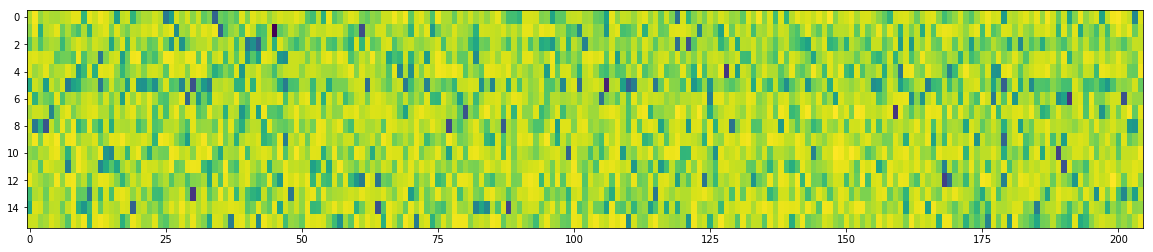

torch.Size([32, 16, 1, 4])


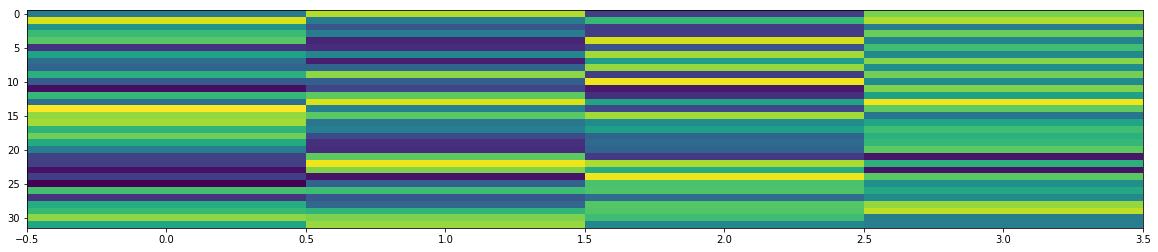

In [11]:
plt.figure(figsize=(20, 4))
plt.imshow(np.log(np.abs(net.cnn1[0].weight[:, 0, :, 0].cpu().data.numpy()) + 1e-7), aspect='auto')
plt.show()
print net.cnn1[2].weight.shape
plt.figure(figsize=(20, 4))
plt.imshow(net.cnn1[2].weight[:, 0, 0, :].cpu().data.numpy(), aspect='auto')
plt.show()

In [77]:
#net_random = SiameseNetwork().cuda()
#net_random.eval()
progress_bar = tnrange(100)
batch_size = 16
test_loss = []
for i in progress_bar:
    a = np.random.choice(range(dataset['testing']['data'].shape[0]), (batch_size,))
    b = np.random.choice(range(dataset['testing']['data'].shape[0]), (batch_size,))
    
    data_one, label_one = collect_data(dataset['testing'], a)
    data_two, label_two = collect_data(dataset['testing'], b)
    
    data_one = whiten(data_one, mean, std)
    data_two = whiten(data_two, mean, std)
    
    data_one = Variable(convert_to_tensor(data_one))
    data_two = Variable(convert_to_tensor(data_two))
    
    same_or_different = np.array(label_one != label_two).astype(np.float)
    
    output_one, output_two = net(data_one, data_two)
    optimizer.zero_grad()
    loss = loss_function(output_one, output_two, Variable(convert_to_tensor(same_or_different)))
    progress_bar.set_description(str(loss.data[0]))
    test_loss.append(loss.data[0])
    
print np.mean(test_loss)

HBox(children=(IntProgress(value=0), HTML(value=u'')))


1.79649787307


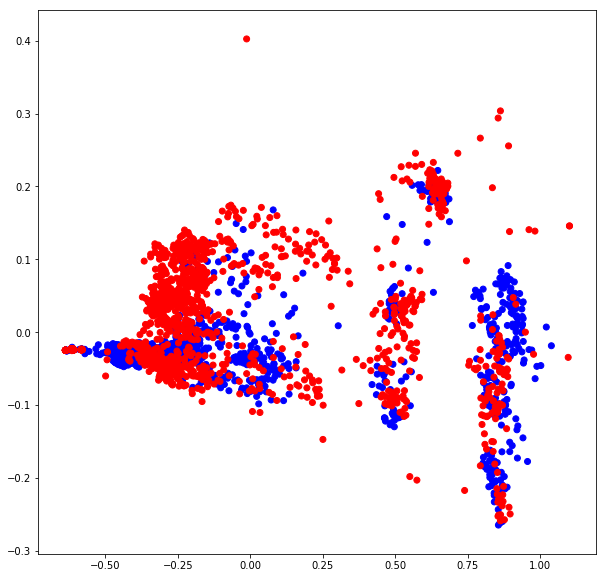

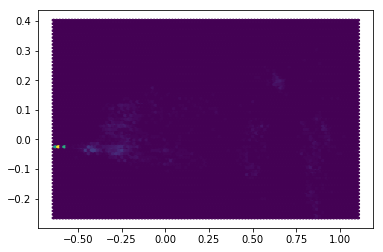

In [79]:
test_embeddings = []
outputs = []
labels = []
guesses = []
split = 'training'
net.eval()
for i in range(dataset[split]['data'].shape[0]):
    data = whiten(dataset[split]['data'][i], mean, std)
    data = Variable(convert_to_tensor(data)).unsqueeze(0)
    label = dataset[split]['label'][i]
    labels.append(label)
    output = net.forward_once(data)
    #guess = net_classifier(output)
    output = output.squeeze(0).data.cpu().numpy()
    #guesses.append(np.round(guess.squeeze(0).data.cpu().numpy()))
    outputs.append(output)

output = np.array(outputs)

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#transform = TSNE(n_components=2)
transform = PCA(n_components=2)

output_transform = transform.fit_transform(output)
c = ['red', 'blue']
colors = [c[int(l[0])] for l in labels]

plt.figure(figsize=(10,10))
plt.scatter(output_transform[:, 0], output_transform[:, 1], color=colors)
#plt.xlim([-.00025, .00025])
#plt.ylim([-.00025, .00025])
plt.show()

plt.hexbin(output_transform[:, 0], output_transform[:, 1])
#plt.xlim([-.00025, .00025])
#plt.ylim([-.00025, .00025])
plt.show()

In [85]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
clf = svm.SVC(kernel='linear')
#clf = KNeighborsClassifier(1)
clf.fit(output, np.array(labels).flatten())
from sklearn.metrics import confusion_matrix

confusion_matrix(np.array(labels).flatten(), clf.predict(output))

array([[162,   0],
       [117,   0]])

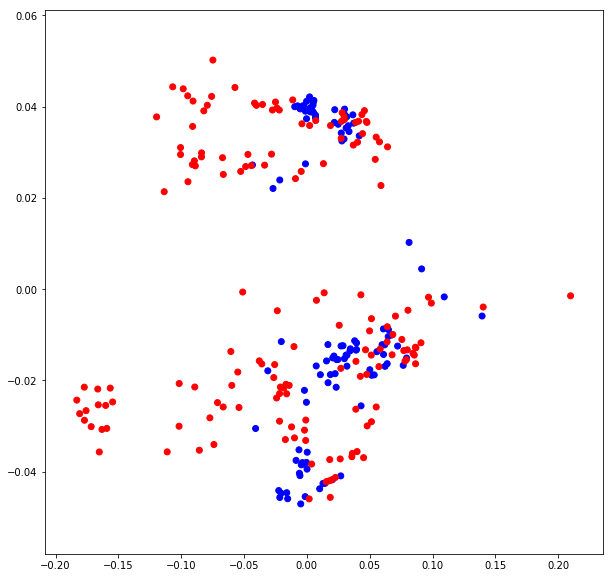

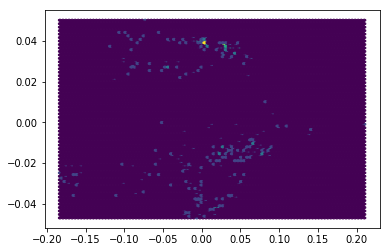

In [83]:
test_embeddings = []
outputs = []
labels = []
guesses = []
split = 'testing'
net.eval()
for i in range(dataset[split]['data'].shape[0]):
    data = whiten(dataset[split]['data'][i], mean, std)
    data = Variable(convert_to_tensor(data)).unsqueeze(0)
    label = dataset[split]['label'][i]
    labels.append(label)
    output = net.forward_once(data)
    #guess = net_classifier(output)
    output = output.squeeze(0).data.cpu().numpy()
    #guesses.append(np.round(guess.squeeze(0).data.cpu().numpy()))
    outputs.append(output)

output = np.array(outputs)

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#transform = TSNE(n_components=2)
transform = PCA(n_components=2)

output_transform = transform.fit_transform(output)
c = ['red', 'blue']
colors = [c[int(l[0])] for l in labels]

plt.figure(figsize=(10,10))
plt.scatter(output_transform[:, 0], output_transform[:, 1], color=colors)
#plt.xlim([-.00025, .00025])
#plt.ylim([-.00025, .00025])
plt.show()

plt.hexbin(output_transform[:, 0], output_transform[:, 1])
#plt.xlim([-.00025, .00025])
#plt.ylim([-.00025, .00025])
plt.show()

In [84]:
#TODO - use magnitude of vector 
#TODO - establish baselines - rank surface windows in terms of high-pass energy

cm = confusion_matrix(np.array(labels).flatten(), clf.predict(output))

print np.sum(confusion_matrix(np.array(labels).flatten(), clf.predict(output)), axis=0) / float(np.sum(cm))

cm = cm / float(np.sum(cm))
print cm

print np.sum(np.array(labels).flatten() == clf.predict(output)) / float(len(labels))

[ 1.  0.]
[[ 0.58064516  0.        ]
 [ 0.41935484  0.        ]]
0.58064516129


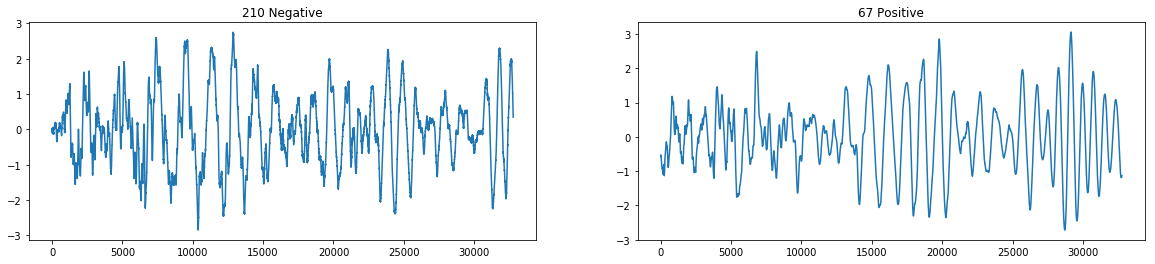

0.174094632268


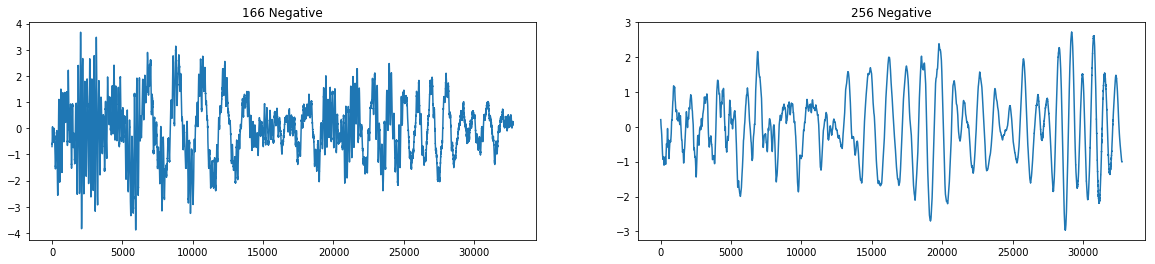

2.7150812149


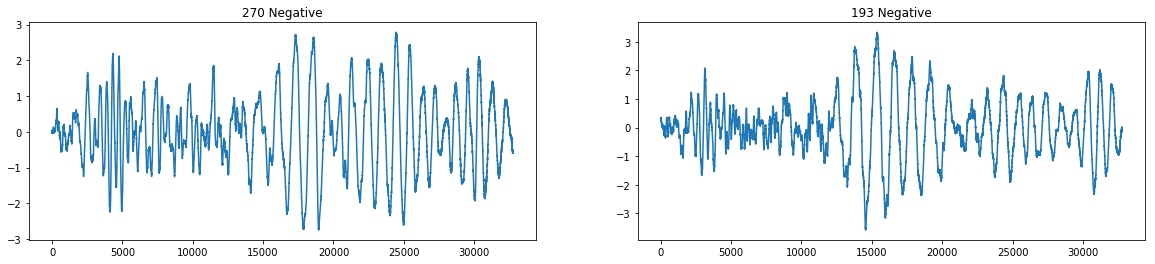

1.23855257034


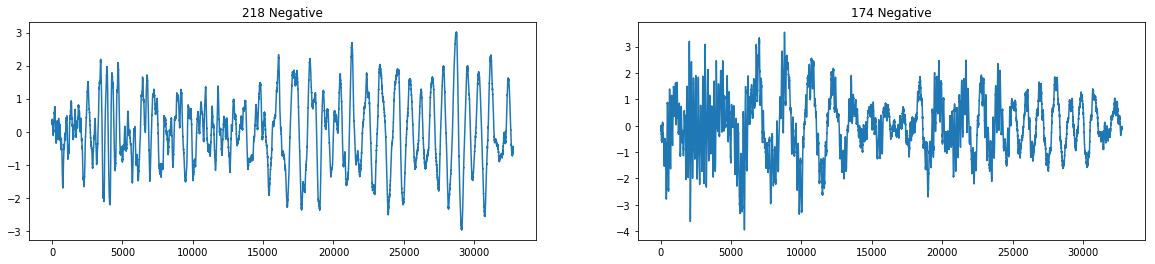

2.86376905441


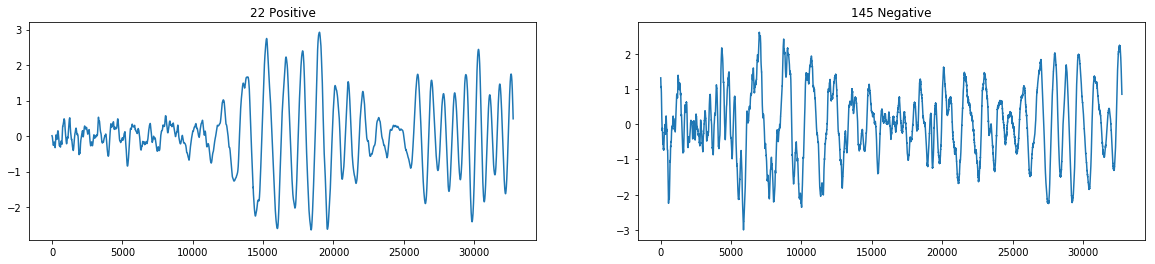

0.128504261374


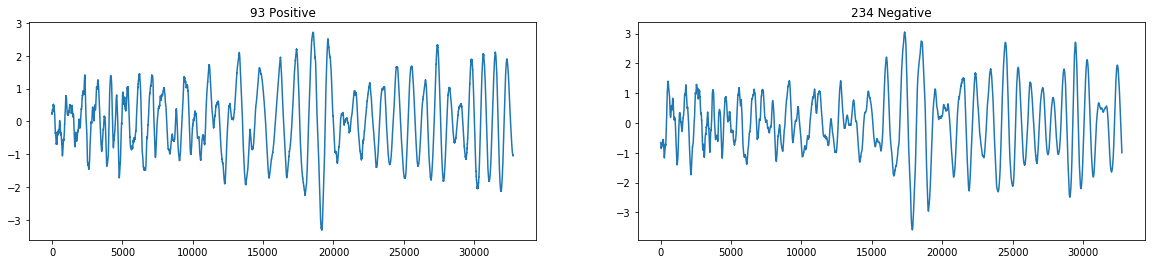

0.0506896004081


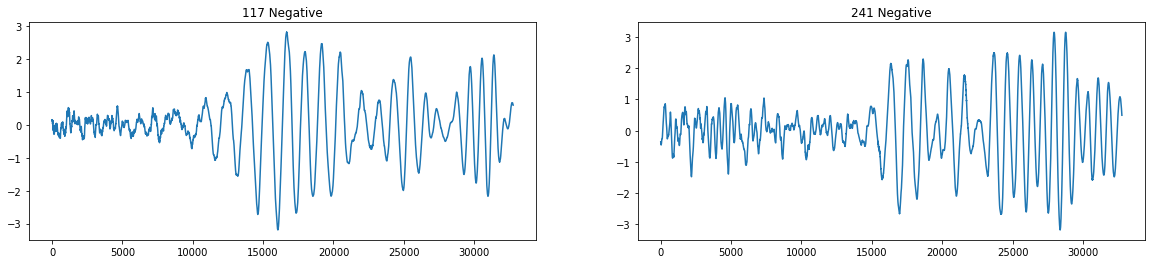

1.93830049038


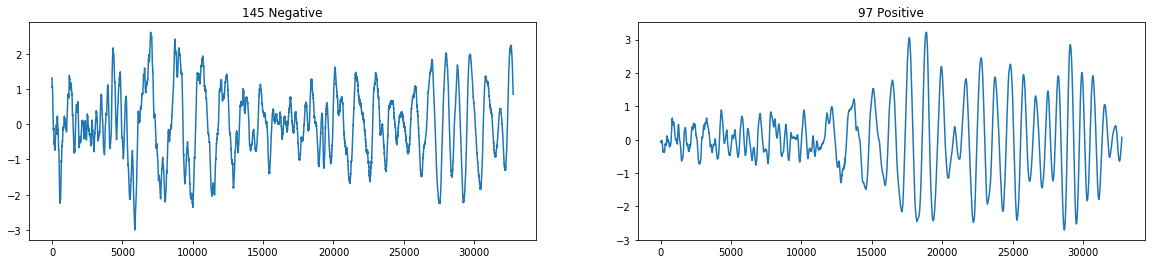

0.100107654929


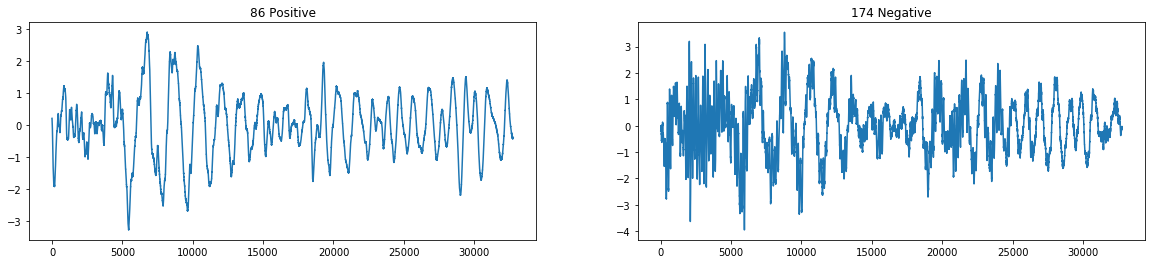

0.0886742472649


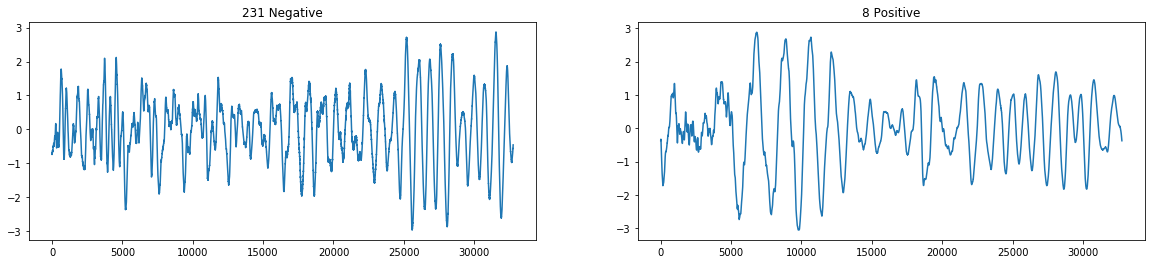

0.0918918475509


In [70]:
def show_siamese(i, j, split):
    labels = ['Negative', 'Positive']
    plt.figure(figsize=(20, 4))
    plt.subplot(121)
    plt.plot(dataset[split]['data'][i])
    plt.title(str(i) + ' ' + labels[int(dataset[split]['label'][i][0])])
    plt.subplot(122)
    plt.plot(dataset[split]['data'][j])
    plt.title(str(j) + ' ' + labels[int(dataset[split]['label'][j][0])])
    plt.show()
    
    data_one = Variable(convert_to_tensor(dataset[split]['data'][i]).unsqueeze(0))
    data_two = Variable(convert_to_tensor(dataset[split]['data'][j]).unsqueeze(0))
    output_one, output_two = net(data_one, data_two)
    same_or_different =  int(dataset[split]['label'][j][0]) == int(dataset[split]['label'][i][0]) 
    loss = loss_function(output_one, output_two, same_or_different)
    print loss.data[0]
    #print net_classifier(net.forward_once(data_one)), net_classifier(net.forward_once(data_two))
net.eval()
for i in range(0, 10):
    show_siamese(random.choice(range(dataset['testing']['data'].shape[0])),
                 random.choice(range(dataset['testing']['data'].shape[0])),
                 'testing')